In [1]:
%matplotlib inline

import math
import random

from collections import namedtuple
from itertools import count
from copy import deepcopy

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym

from PIL import Image
from torch.autograd import Variable

env = gym.make('CartPole-v0').unwrapped


is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

use_cuda = torch.cuda.is_available()

[2017-06-29 09:26:20,791] Making new env: CartPole-v0


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class Replaymemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight.data)
        
        
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            Flatten(),
            nn.Linear(896, 2),
            )
        self.main.apply(initialize_weights)
        
    def forward(self, x):
        x = self.main(x)
        return x

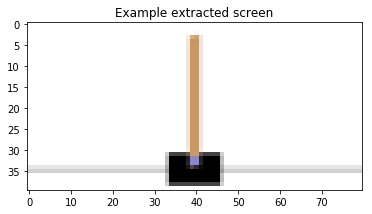

In [4]:
resize = T.Compose([
    T.ToPILImage(),
    T.Scale(40, interpolation=Image.CUBIC),
    T.ToTensor()
])

screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)


def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = resize(screen).unsqueeze(0)
    if use_cuda:
        screen = screen.cuda()
    return screen

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())
memory = Replaymemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) *\
        math.exp(-1.*steps_done/EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        state = Variable(state, volatile=True)
        if use_cuda:
            state = state.cuda()
        action = model(state).data.max(1)[1]
        return action
    else:
        action = torch.LongTensor([[random.randrange(2)]])
        if use_cuda:
            action = action.cuda()
        return action
    
episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations.numpy())
    if len(durations) >= 100:
        means = durations.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [6]:
last_sync = 0


def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)))
    if use_cuda:
        non_final_mask = non_final_mask.cuda()
        
    non_final_next_states = Variable(
        torch.cat([s for s in batch.next_state if s is not None]))
    
    if use_cuda:
        non_final_next_states = non_final_next_states.cuda()
    
    state_batch = Variable(torch.cat(batch.state))
    
    if use_cuda:
        state_batch = state_batch.cuda()
        
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))
    
    state_action_values = model(state_batch).gather(1, action_batch)
    
    next_state_values = Variable(torch.zeros(BATCH_SIZE))
    if use_cuda:
        next_state_values = next_state_values.cuda()
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    
    # next_state_values.volatile = False
    expected_state_action_values = next_state_values * GAMMA + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values,
                            expected_state_action_values)
    
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

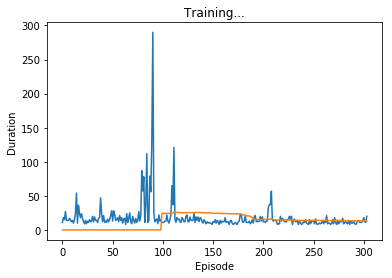

KeyboardInterrupt: 

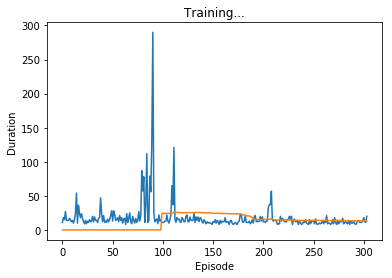

In [7]:
num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = torch.Tensor([reward])
        if use_cuda:
            reward = reward.cuda()

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
            
print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()